In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pmdarima.arima import auto_arima
from gensim.models import KeyedVectors
import tensorflow as tf
import spacy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from pylab import rcParams
import re
from datetime import date
import scienceplots

rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
%matplotlib inline


In [31]:
items = pd.read_csv("./items.csv")
shops = pd.read_csv("./shops.csv")
item_categories = pd.read_csv("./item_categories.csv")
train = pd.read_csv("./sales_train.csv")
test = pd.read_csv("./test.csv")


In [32]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [33]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [34]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [35]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [36]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [37]:
# Check missing values
print("items:\n" + str(items.isna().sum()) + "\n")
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")


items:
item_name           0
item_id             0
item_category_id    0
dtype: int64

train:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

test:
ID         0
shop_id    0
item_id    0
dtype: int64



Preprocessing

train

In [38]:
print(f"The number of shops: {train['shop_id'].unique().shape[0]}")
print(f"The number of items: {train['item_id'].unique().shape[0]}")

The number of shops: 60
The number of items: 21807


format: date

In [39]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

Anomalies in item_price column

In [40]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [41]:
train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [42]:
missing_price = train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973) & (train['item_price'] > 0)]
train.loc[train['item_price'] < 0, "item_price"] = missing_price['item_price'].mean()


In [43]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


Anomalies in item_cnt_day column

In [44]:
negative_train = train[train['item_cnt_day'] < 0]

In [45]:
# Statistics: item_price
train['item_price'].describe()

count    2.935849e+06
mean     8.908537e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [46]:
# Statistics: item_price of records with item_cnt_day < 0
negative_train['item_price'].describe()

count     7356.000000
mean      1442.945623
std       2419.680132
min          0.500000
25%        349.000000
50%        799.000000
75%       1699.000000
max      33490.000000
Name: item_price, dtype: float64

In [47]:
train['item_cnt_day'] = np.where(train['item_cnt_day'] < 0, 0, train['item_cnt_day'])

Select shops that appear in test set

In [48]:
print(f"The number of shops in train data: {train['shop_id'].unique().shape[0]}")
print(f"The number of shops in test data: {test['shop_id'].unique().shape[0]}")


The number of shops in train data: 60
The number of shops in test data: 42


In [49]:
train = train[train['shop_id'].isin(test['shop_id'].unique().tolist())]
train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,0.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


Date aggregation

In [50]:
train = pd.merge(train, 
                 train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index(),
                 on=['date_block_num', 'shop_id', 'item_id'],
                 how='left')
train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month
0,2013-01-02,0,59,22154,999.00,1.0,1.0
1,2013-01-03,0,25,2552,899.00,1.0,1.0
2,2013-01-05,0,25,2552,899.00,0.0,1.0
3,2013-01-06,0,25,2554,1709.05,1.0,1.0
4,2013-01-15,0,25,2555,1099.00,1.0,1.0
...,...,...,...,...,...,...,...
2413241,2015-10-10,33,25,7409,299.00,1.0,3.0
2413242,2015-10-09,33,25,7460,299.00,1.0,3.0
2413243,2015-10-14,33,25,7459,349.00,1.0,1.0
2413244,2015-10-22,33,25,7440,299.00,1.0,1.0


test

In [51]:
print("Items appear in test set but not in train set:")
len(set(test["item_id"].unique().tolist()) - set(train["item_id"].unique().tolist()))

Items appear in test set but not in train set:


384

In [52]:
train_g = train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index()
train_g


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1323790,33,59,22087,6.0
1323791,33,59,22088,2.0
1323792,33,59,22091,1.0
1323793,33,59,22100,1.0


Visualization

Can different months effect on the amount of product?    
number of months: "date_block_num"    
amount of products: ["item_cnt_day"].sum()

In [53]:
train.groupby(by="date_block_num")["item_cnt_day"].sum()

date_block_num
0      92193.0
1      90716.0
2     114905.0
3      84189.0
4      85763.0
5     103566.0
6      94986.0
7     101691.0
8     107569.0
9      98640.0
10    105871.0
11    149597.0
12     93532.0
13     89569.0
14     93257.0
15     77525.0
16     78795.0
17     79062.0
18     74499.0
19     84010.0
20     81474.0
21     81071.0
22     96693.0
23    139631.0
24     91676.0
25     72293.0
26     71656.0
27     71979.0
28     67005.0
29     60220.0
30     60084.0
31     65280.0
32     72365.0
33     65385.0
Name: item_cnt_day, dtype: float64

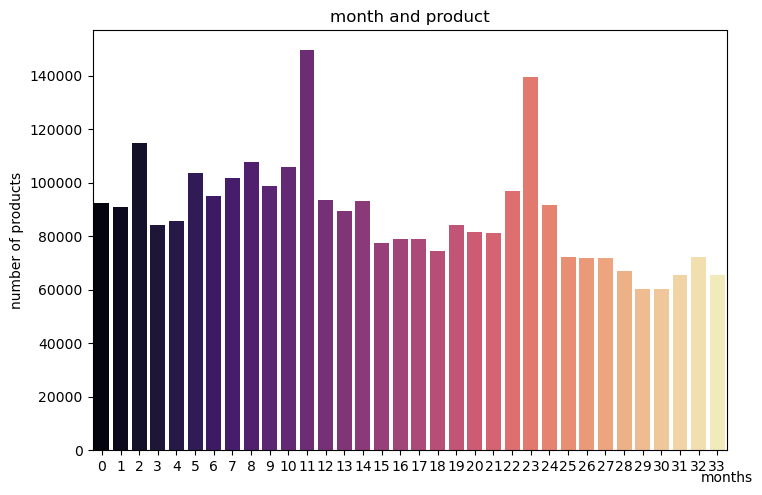

In [54]:
plt.figure(figsize=(18, 12))
plt.xticks(size=1)
ax1 = plt.subplot(2,2,1)
sns.barplot(ax=ax1, 
            palette="magma",
            y=train.groupby(by="date_block_num")["item_cnt_day"].sum().unique(),
            x=np.arange(34)
           )
ax1.set(ylabel="number of products", xlabel="months", title="month and product")
ax1.xaxis.set_label_coords(1, -0.05)

How the diffferent date affect same shop's product amount?    
same shop: "shop_id"   
different days:"date"   
amount of prodcuts:"item_cnt_day"

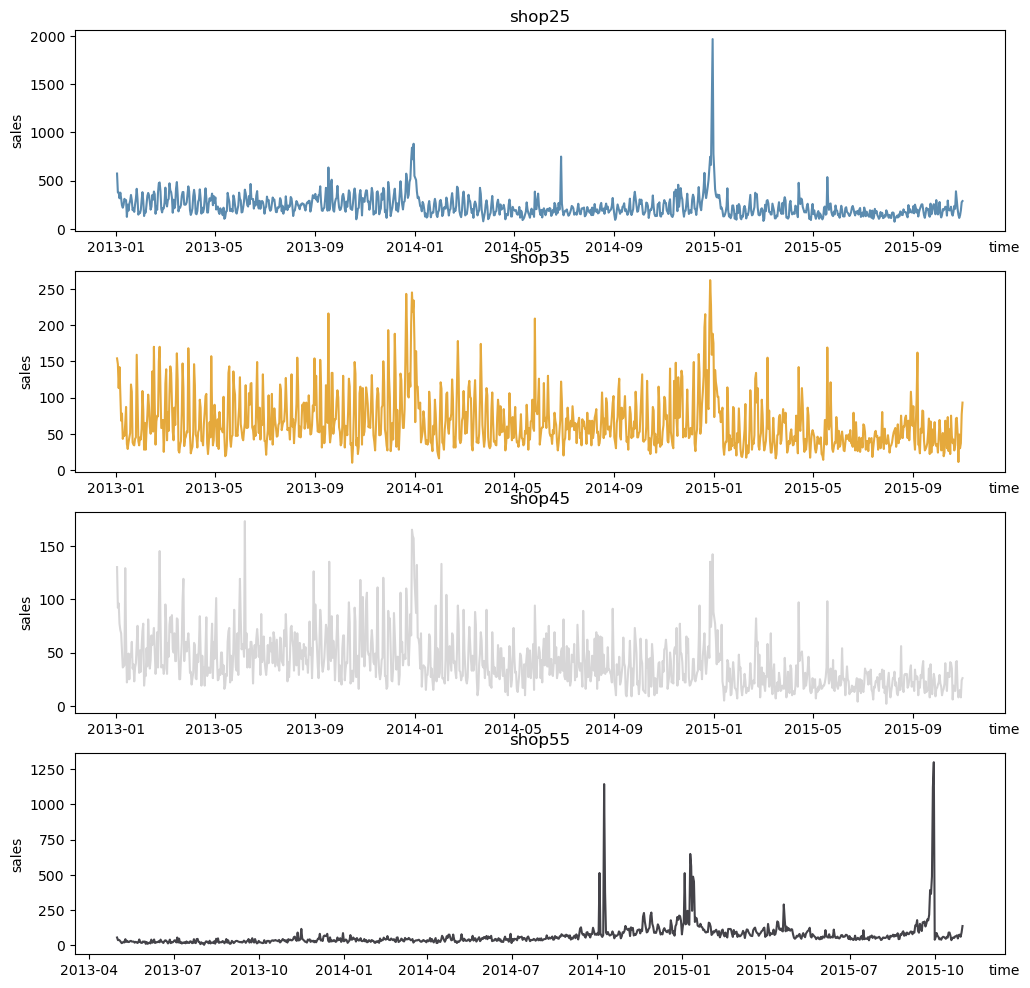

In [55]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
sns.lineplot(ax=axs[0], data=train[train["shop_id"] == 25].groupby(by=["date"]).sum(), 
             x="date", y="item_cnt_day", color="#5B8BAF")
axs[0].set(xlabel="time", ylabel="sales", title="shop25")
axs[0].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[1], data=train[train["shop_id"] == 35].groupby(by=["date"]).sum(), 
             x="date", y="item_cnt_day", color="#E5A93C")
axs[1].set(xlabel="time", ylabel="sales", title="shop35")
axs[1].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[2], data=train[train["shop_id"] == 45].groupby(by=["date"]).sum(), 
             x="date", y="item_cnt_day", color="#D7D6D7")
axs[2].set(xlabel="time", ylabel="sales", title="shop45")
axs[2].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[3], data=train[train["shop_id"] == 55].groupby(by=["date"]).sum(), 
             x="date", y="item_cnt_day", color="#444349")
axs[3].set(xlabel="time", ylabel="sales", title="shop55")
axs[3].xaxis.set_label_coords(1, -0.05)


Different product categories and sales      
#1 number of different product categories    
#2 percentage of sales on different product categories      
#3 average sales of different product categories

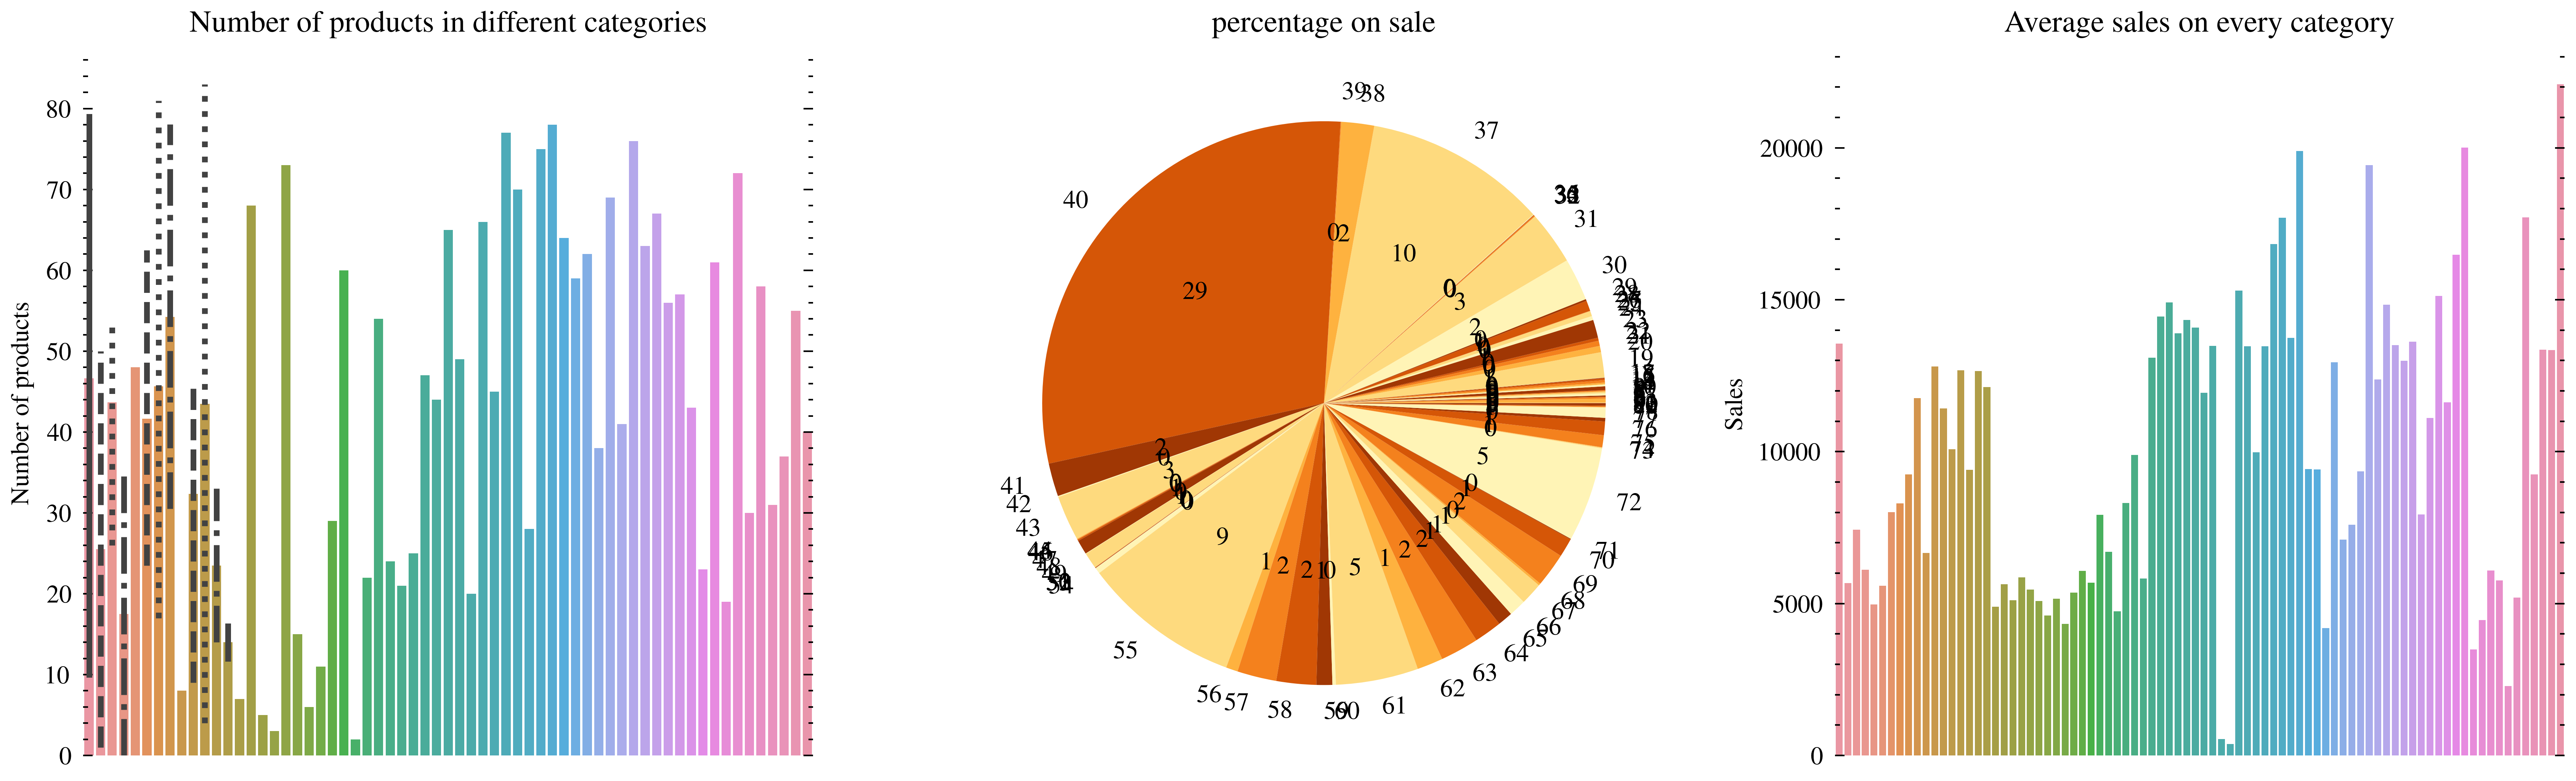

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plt.style.use(['science','ieee'])
sns.despine(bottom = True, left = True)
sns.barplot(ax=axs[0],
            x=items.groupby(by="item_category_id")["item_id"].count(), 
            y=np.arange(84), 
            # palette="Spectral"
           )
axs[0].axes.xaxis.set_visible(False)
axs[0].set(xlabel="Category", ylabel="Number of products", title="Number of products in different categories")
axs[0].xaxis.set_label_coords(1, -0.05)

type_sum = items.groupby(by="item_category_id")["item_id"].sum()
axs[1].pie(type_sum / type_sum.sum(), 
           labels=type_sum.index.to_list(), 
           colors=sns.color_palette("YlOrBr"), 
           autopct='%.0f%%')
axs[1].axes.xaxis.set_visible(False)
axs[1].axes.yaxis.set_visible(False)
axs[1].set(title="percentage on sale")

sns.barplot(ax=axs[2], 
               x=items.groupby(by="item_category_id")["item_id"].mean().index, 
               y=items.groupby(by="item_category_id")["item_id"].mean(),
            #    palette="Spectral"
              )
axs[2].axes.xaxis.set_visible(False)
axs[2].set(xlabel="Category", ylabel="Sales", title="Average sales on every category")
axs[2].xaxis.set_label_coords(1, -0.05)
